In [343]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from src import viral_seq
from src import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction 

From `dictionary_viral_seq.txt` :
* Some NA are present when nucleotides had low coverage
* Nucleotide column format: `pos_position123_variant`
* Amino acid column format: `gene_genenameXYZ_pos_position123_variant`
* 0 indicates abscence of the variant, while 1 indicates its presence

# Import data



In [334]:
df_aa = pd.read_csv("data/viral_seq/OUT_aa_binary_table.txt", sep='\s+')
# We prefer to have integers than index to process data
# But we keep the provided index in case it will be useful later
df_aa.reset_index(inplace=True)
print(df_aa.shape)
df_aa.tail()

(790, 5394)


,index,gene_PC_C_pos_0001_I,gene_PC_C_pos_0001_M,gene_PC_C_pos_0002_Q,gene_PC_C_pos_0002_R,gene_PC_C_pos_0002_STOP,gene_PC_C_pos_0003_L,gene_PC_C_pos_0004_F,gene_PC_C_pos_0005_H,gene_PC_C_pos_0006_L,...,gene_X_pos_0148_Y,gene_X_pos_0149_D,gene_X_pos_0149_N,gene_X_pos_0150_F,gene_X_pos_0151_F,gene_X_pos_0152_T,gene_X_pos_0153_S,gene_X_pos_0154_A,gene_X_pos_0155_STOP,gene_X_pos_0155_W
785,GS-US-330-1401-2016,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0
786,GS-US-330-1401-2018,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
787,GS-US-330-1401-2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
788,GS-US-330-1401-2024,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
789,GS-US-330-1401-2027,0.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,0.0


## Visualize format

In [28]:
def extract_values(df, n):
    cols = df.columns.values[1:] # we slice that way to avoid 'index' column
    lst = []
    for v in cols:
        lst.append(v.split('_')[n])
    # Remove duplicates
    lst = list(dict.fromkeys(lst))
    return lst

### Variants

In [29]:
lst = extract_values(df_aa, -1)
print("Variants ({} items): {}".format(len(lst), lst))

Variants (21 items): ['I', 'M', 'Q', 'R', 'STOP', 'L', 'F', 'H', 'C', 'D', 'N', 'V', 'S', 'T', 'A', 'P', 'E', 'K', 'G', 'W', 'Y']


This is expected: 20 amino acids + a STOP codon. **Note that all positions in the genome do NOT contain all 21 items**. I guess a variable was created for every mutated a.a. for a given position.

### Genes



In [30]:
lst = extract_values(df_aa, 1)
print(lst)

['PC', 'Pol', 'S', 'X']


That's expected: PC is core protein, Pol is the DNA polymerase, S surface antigen, X not well known (must be implied in some TF encoding).

### Positions

We simply want to check wheter there are some missing positions.

In [248]:
lst = extract_values(df_aa, -2)
# Convert to int
lst = [ int(n) for n in lst ]
ok = True
# Simply iterate from 0 to len-1 and compare with values in the list
for i, n in enumerate(lst) :
    if i != n-1: ok = False
print("The int list has no gaps:", ok)
positions = viral_seq.collapse_variants(df_aa.columns.drop('index'))
print("There are {} amino acid positions in total in the viral genome.".format(len(positions)))

The int list has no gaps: True
There are 1613 amino acid positions in total in the viral genome.


Since HBV has partial double-stranded DNA, it has two different genome length. About 3000 nucleotides for the long strand, and ~ 2000 nucleotides for the short strand. This makes about 1000 and 670 amino acids. However, some genes are **overlapping, thus we have more amino acids depending on the reading frame taken into account**.

# Data glimpse

## NAN values

### Per variant

We basically count non-NAN values with `DataFrame.count()`. 

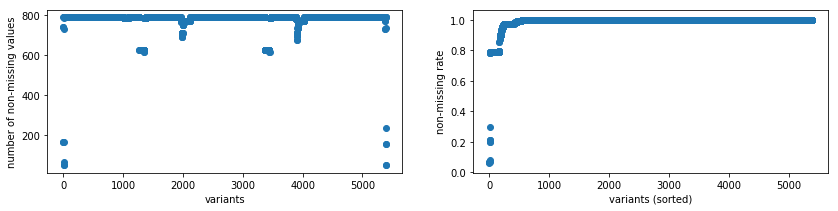

In [335]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
# Count the non-missing values
variants_counts = df_aa.count()
r = np.arange(1, len(variants_counts)+1)
# Plot it
ax[0].scatter(x=r, y=variants_counts);
ax[0].set_xlabel('variants'); ax[0].set_ylabel('number of non-missing values')
# Want to sort it
N_ind = df_aa.shape[0]
missing_rates = variants_counts.sort_values()
missing_rates = missing_rates/N_ind
plt.scatter(x=np.arange(1, len(variants_counts)+1), y=missing_rates);
plt.ylabel('non-missing rate'); plt.xlabel('variants (sorted)');

We see that some variables have very few non-NA values *(we should remove them...)*. Let's sort them by the rate of non-missing values, and compute the percentage of missing values for each variable.

### Per individual

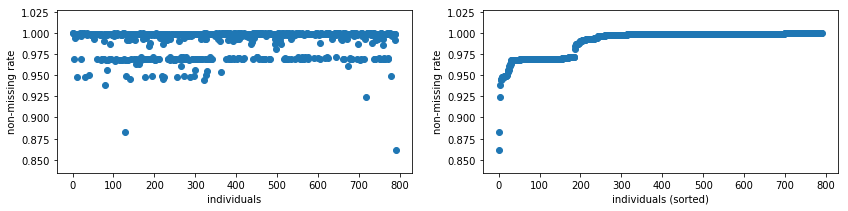

In [340]:

fig, ax = plt.subplots(1, 2, figsize=(14, 3))
# Count non-missing values per individual 
inds_counts = df_aa.count(axis=1)
# Transform counts into frequencies
N_variants = df_aa.shape[1]
inds_counts = inds_counts/N_variants;
# Plot
rng = np.arange(1, len(inds_counts)+1)
ax[0].scatter(x=rng, y=inds_counts);
ax[0].set_xlabel('individuals'); ax[0].set_ylabel('non-missing rate')
ax[1].scatter(x=rng, y=inds_counts.sort_values())
ax[1].set_xlabel('individuals (sorted)'); ax[1].set_ylabel('non-missing rate');

The worst case still has only ~15% of missing values. 

## Mutation rates per INDIVIDUAL

We transpose the DataFrame.

### Plots

In [226]:
dfT = df_aa.transpose()
dfT.drop('index', axis=0, inplace=True)
dfT.head()

,0,1,2,3,4,5,6,7,8,9,...,780,781,782,783,784,785,786,787,788,789
gene_PC_C_pos_0001_I,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,0,0
gene_PC_C_pos_0001_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,NaN,1,1
gene_PC_C_pos_0002_Q,1,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
gene_PC_C_pos_0002_R,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
gene_PC_C_pos_0002_STOP,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


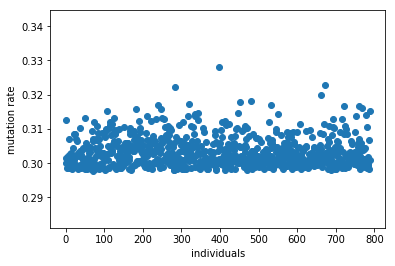

In [119]:
rates = dfT.apply(np.mean)
plt.scatter(x=rates.index, y=rates);
plt.xlabel('individuals')
plt.ylabel('mutation rate');

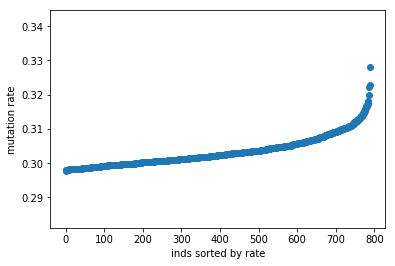

In [123]:
plt.scatter(x=rates.index, y=rates.sort_values());
plt.xlabel('inds sorted by rate')
plt.ylabel('mutation rate');

Note that those rates are ignoring `NaN` values.

### Summary statistics

count    790.000000
mean       0.303379
std        0.004363
min        0.297805
25%        0.300204
50%        0.302260
75%        0.305463
max        0.327945
dtype: float64


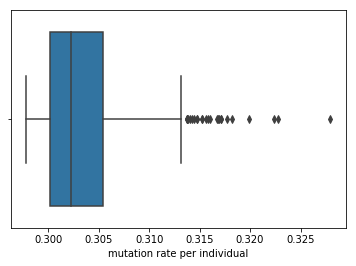

In [181]:
# Summary statistics
print(rates.describe())
# Boxplot
sns.boxplot(rates); plt.xlabel('mutation rate per individual');

### Individuals with higher mutation rates

In [139]:
rates.sort_values(ascending=False).head(10)

397    0.327945
673    0.322786
283    0.322352
662    0.319939
480    0.318217
452    0.317734
320    0.317155
240    0.317129
532    0.316877
721    0.316797
dtype: float64

## Mutation rates per variable/column

Here we look at the rates (mean) of mutations **for each column**, i.e. we treat `gene_XX_pos_YY_Z1` and `gene_XX_pos_YY_Z2` separately.

*Note: intuitively, we would like to apply the computation with `axis=0` (which is the default axis). However, pandas iterates the DataFrame by row, thus we must specify `axis=1` instead.*

In [175]:
# Here, we compute the mean from dtT with axis=1
var_rates = dfT.apply(np.mean, axis=1)
print("Shape =", var_rates.shape)
print("Head (2 items):")
print(var_rates.head(2))
var_rates.describe()

Shape = (5393,)
Head (2 items):
gene_PC_C_pos_0001_I    0.001348
gene_PC_C_pos_0001_M    1.000000
dtype: float64


count    5393.000000
mean        0.303034
std         0.429595
min         0.001266
25%         0.002532
50%         0.010139
75%         0.905072
max         1.000000
dtype: float64

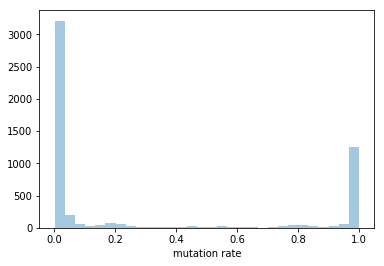

In [162]:
sns.distplot(var_rates, kde=False, bins=30);
plt.xlabel('mutation rate');

We see that most of the variables have very small mutation rate (< 10%) or very high mutation rate (>90%). Let's look at those extremities: 

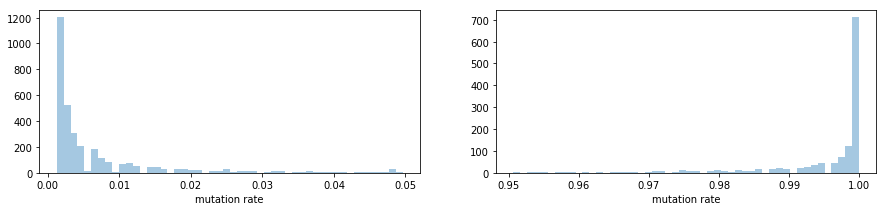

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))
# Define bounds of extremities
lower_bound = 0.05
upper_bound = 0.95
# Plot histograms
sns.distplot(var_rates[var_rates <= lower_bound], kde=False, ax=ax[0]);
ax[0].set_xlabel('mutation rate')
sns.distplot(var_rates[var_rates >= upper_bound], kde=False, ax=ax[1])
ax[1].set_xlabel('mutation rate');

### Most conserved variants


In [294]:
variants_rate_1 = var_rates[var_rates == 1.0].index.values
print(len(variants_rate_1), "variants with mutation rate of 1.00")
print("Those variants are contained in the following genes:", 
      viral_seq.collapse_variants(variants_rate_1, pos=False))
positions = viral_seq.collapse_variants(variants_rate_1)
print("At a total of {} positions".format(len(positions)))

710 variants with mutation rate of 1.00
Those variants are contained in the following genes: ['gene_PC_C', 'gene_Pol', 'gene_S', 'gene_X']
At a total of 710 positions


## Mutations per position

Here we are interested in the variants that exist in each position. One metric we could get from this is the variance per gene.

**NOTE: we create a DataFrame that uses MultiIndex**.

In [249]:
# Make the index as a column
df_pos = dfT.reset_index()
# Process the 'index' column to extract information (gene, position, variant)
df_pos['gene'] = df_pos['index'].apply(lambda s: s.split('_')[1])
df_pos['pos'] = df_pos['index'].apply(lambda s: int(s.split('_')[-2]))
df_pos['variant'] = df_pos['index'].apply(lambda s: s.split('_')[-1])

# Create a MultiIndex with the extracted information
df_pos.set_index(['gene', 'pos', 'variant'], inplace=True)
# 'index' column is useless yet (does not provide any extra information)
df_pos.drop(columns=['index'], inplace=True)
df_pos

0    1    2    3    4    5    6    7    8    9    ...  780  \
gene pos variant                                                    ...        
PC   1   I          0    0    0    0    0    0    0    0    0    0  ...    0   
         M          1    1    1    1    1    1    1    1    1    1  ...    1   
     2   Q          1    1  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...  NaN   
         R          0    0  NaN  NaN  NaN    0  NaN  NaN  NaN  NaN  ...  NaN   
         STOP       0    0  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...  NaN   
     3   L        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
     4   F        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
     5   H        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
     6   L          1    1    1    1    1    1    1  NaN    1    1  ...    1   
     7   C          1    1    1    1    1    1    1    1    1    1  ...    1   
     8   L          1    1    1    1    1    1    1    1    1    1  ...    1   
     9   D          0    0    0    0    0    0    0    0    0    0  ...    0   
         I          1    1    1    1    1    1    1    1    1    1  ...    1   
         N          0    0    0    0    0    0    0    0    0    0  ...    0   
         V          0    0    0    0    0    1    0    1    0    1  ...    1   
     10  I          1    1    1    1    1    1    1    1    1    1  ...    1   
         N          0    0    0    0    0    0    0    0    0    0  ...    0   
         S          0    0    0    0    0    0    0    0    0    0  ...    0   
         T          0    0    0    0    0    0    0    0    0    0  ...    0   
     11  F          0    0    0    0    0    0    0    0    0    0  ...    0   
         S          1    1    1    1    1    1    1    1    1    1  ...    1   
     12  C          1    1    1    1    1    1    1    1    1    1  ...    1   
     13  A          0    0    0    0    0    0    0    0    0    0  ...    0   
         S          1    1    1    0    1    0    1    1    1    1  ...    1   
         T          0    0    0    1    0    1    0    0    0    0  ...    0   
     14  C          1    1    1    1    1    1    1    1    1    1  ...    1   
         R          0    0    0    0    0    0    0    0    0    0  ...    0   
     15  L          0    0    0    0    0    0    0    0    0    0  ...    0   
         P          1    1    1    1    1    1    1    1    1    1  ...    1   
         S          0    0    0    0    0    0    0    0    0    0  ...    0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
X    141 L          1    1    1    1    1    1    1    1    1    1  ...    1   
         M          0    0    0    0    0    0    0    0    0    0  ...    0   
         STOP       0    0    0    0    0    0    0    0    0    0  ...    0   
         V          0    0    0    0    0    0    0    0    0    0  ...    0   
         W          0    0    0    0    0    0    0    0    0    0  ...    0   
     142 V          1    1    1    1    1    1    1    1    1    1  ...    1   
     143 C          1    1    1    1    1    1    1    1    1    1  ...    1   
         P          0    0    0    0    0    0    0    0    0    0  ...    0   
         R          0    0    0    0    0    0    0    0    0    0  ...    0   
     144 A          0    0    1    1    0    1    0    0    0    0  ...    0   
         L          0    0    0    0    0    0    0    0    0    0  ...    0   
         P          0    0    0    0    0    0    0    0    0    0  ...    0   
         S          1    1    0    0    1    0    1    1    1    1  ...    1   
         V          0    0    0    0    0    0    0    0    0    0  ...    0   
     145 P          1    1    1    1    1    1    1    1    1    1  ...    1   
     146 A          1    1    1    1    1    1    1    1    1    1  ...    1   
         S          0    0    0    1    0    0    0    0    0    0  ...    0   
     147 P        

### Note on multi-indexing

One can basically slice the data structure with tuples, i.e. `('geneX', Y, 'variantZ')`. Example: select the value in gene X, at position 141, variant M:

    df_pos.loc[ ('X', 141, 'M') ]
    
To perform **partial splicing**, one can let items from a tuple empty. Example: select all VARIANTS from gene PC, at position 1

    df_pos.loc[('PC', 1, )]
    
Example: select all POSITIONS from gene PC

    df_pos.loc['PC']

### Group data by position

The goal is to show the number of variants that are present at each position (number of variants with a value of `1`). 

In [347]:
# Warning: this is a slow computation, takes several minutes
# Thus we use a custom 'manage_pickle' function
def group_by_pos():
    return df_pos.groupby(level=['gene', 'pos']).sum()

df_grouped = common.manage_pickle(path='data/viral_seq_grouped', fun=group_by_pos)
df_grouped

manage_pickle: the file 'data/viral_seq_grouped' has been loaded


0    1    2    3    4    5    6    7    8    9    ...  780  781  \
gene pos                                                    ...             
PC   1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     2    1.0  1.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     6    1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...  1.0  0.0   
     7    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     8    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     9    1.0  1.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0  2.0  ...  2.0  1.0   
     10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     11   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     12   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     13   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     14   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     15   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     16   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     17   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  2.0   
     18   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     19   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     20   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     21   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  2.0   
     22   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     23   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     24   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     25   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     26   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     27   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     28   1.0  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  ...  1.0  1.0   
     29   1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     30   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
X    126  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     127  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     128  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     129  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     130  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     131  1.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     132  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     133  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     134  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     135  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     136  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     137  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     138  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     139  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     140  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     141  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     142  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     143  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     144  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
     1

# Process NaN values

By looking at the plot showing the non-missing values, we see that a few values are below 50%, some are clustered around 80%, and all others lie around 100%. We need to choose a threshold that will lead to exclusion of variants and individuals that have a high rate of missing values.

First, we'll focus on *variants* with high rates of missing values. 

In [349]:
# Define the maximal accepted missing rate (for variants, not individuals)
variants_threshold_max_missing = 0.5
# Use of the variants_counts defined at the top of the notebook

#
# variants_to_exclude = variants_counts()
#